In [1]:
import braindecode
from braindecode.datautil import load_concat_dataset
from braindecode.preprocessing.windowers import create_fixed_length_windows
from braindecode.datasets.base import BaseConcatDataset
import torch
from torch.utils.data import DataLoader
import sys
sys.path.insert(0,'../')
from libs.ssl_data import *
from libs.ssl_model import *
from libs.ssl_task import *
%load_ext autoreload
%autoreload 2

In [10]:
ds = load_concat_dataset('data/ds005505_preprocessed', preload=False)
# Extract windows
fs = ds.datasets[0].raw.info['sfreq']
window_len_s = 2
window_len_samples = int(fs * window_len_s)
window_stride_samples = int(fs * window_len_s) # non-overlapping
windows_ds = create_fixed_length_windows(
    ds, start_offset_samples=0, stop_offset_samples=None,
    window_size_samples=window_len_samples,
    window_stride_samples=window_stride_samples, drop_last_window=True,
    preload=False)

In [26]:
simclr_sampler = SimCLR.SimCLRSampler(windows_ds.get_metadata(), tau_pos=10000)

len metadata 28792
n_recordings 136


/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/braindecode/datasets/base.py:575: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat(all_dfs)


In [27]:
simclr_sampler._sample_pair()

(3865, 3878)

In [ ]:
import torch
import torch.nn.functional as F

# Input tensor with class indices
# Apply one-hot encoding
one_hot_encoded = F.one_hot(torch.arange(10), num_classes=10).float
# one_hot_encoded[:,10:] = one_hot_encoded[:,:10]
# one_hot_encoded.float()
masks = torch.nn.functional.one_hot(torch.arange(10),num_classes=10).bool()
torch.exp(one_hot_encoded.masked_fill(masks == 1, float('-inf')))

tensor([[-inf, 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., -inf, 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., -inf, 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., -inf, 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., -inf, 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., -inf, 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., -inf, 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., -inf, 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., -inf, 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., -inf]])

In [17]:
# Define two 1-D tensors
v1 = torch.tensor([1., 2., 3.])
v2 = torch.tensor([4., 5., 6.])

# Method 1: Using torch.dot()
dot_product1 = torch.dot(v1, v2)
print("Dot product using torch.dot():", dot_product1)

# Method 2: Using torch.matmul() with explicit transpose
v2_transposed = v2.reshape(-1, 1)  # Reshape v2 to a row vector (n,1)
v1_reshaped = v1.reshape(1, -1)    # Reshape v1 to a column vector (1,n)
dot_product2 = torch.matmul(v2_transposed, v1_reshaped)
print("Dot product using torch.matmul():")
print (dot_product2)

Dot product using torch.dot(): tensor(32.)
Dot product using torch.matmul():
tensor([[ 4.,  8., 12.],
        [ 5., 10., 15.],
        [ 6., 12., 18.]])


In [18]:
-1.0000e+09

-1000000000.0

In [32]:
import importlib

def get_class_from_string(class_path: str):
    """
    Dynamically imports a class from a string representation of its path.

    Args:
        class_path: A string representing the full path to the class,
                    e.g., 'module.submodule.ClassName'.

    Returns:
        The class object if found, otherwise raises ImportError or AttributeError.
    """
    try:
        module_path, class_name = class_path.rsplit('.', 1)
        module = importlib.import_module(module_path)
        return getattr(module, class_name)
    except ImportError as e:
        raise ImportError(f"Could not import module '{module_path}': {e}")
    except AttributeError:
        raise AttributeError(f"Class '{class_name}' not found in module '{module_path}'")


In [ ]:
import yaml
from lightning.pytorch.cli import LightningArgumentParser
import lightning as L
config = '../runs/config_Regression.yaml'
with open(config, 'r') as f:
    config_dict = yaml.safe_load(f)

    parser = LightningArgumentParser()
    # parser.add_lightning_class_args(L.Trainer, 'trainer')
    parser.add_lightning_class_args(LitSSL, 'model')
    parser.add_class_arguments(get_class_from_string(config_dict['model']['init_args']['encoder']['init_args']['activation_first_conv_nonlin']['class_path']), nested_key='model.encoder.activation_first_conv_nonlin')
    parser.add_lightning_class_args(config_dict['model']['init_args']['encoder'], 'model.encoder')
    # parser.add_class_arguments(SSLHBNDataModule, 'data', fail_untyped=False)
    config = parser.parse_object(config_dict)
    # objects = parser.instantiate_classes(config)
    # %tb
    # print(config['model'])

lightning_class <class 'libs.ssl_utils.LitSSL'>
nested key model
args ['model.encoder', 'model.encoder_emb_size', 'model.emb_size', 'model.dropout']


ArgumentError: argument --model.encoder: conflicting option string: --model.encoder

In [ ]:
all_ds = load_concat_dataset('data/ds005510_preprocessed', preload=False)

In [ ]:
filtered_ds = []
for ds in all_ds.datasets:
    ds.target_name = 'sex'
    filtered_ds.append(ds)
all_ds = BaseConcatDataset(filtered_ds)
# Extract windows
fs = all_ds.datasets[0].raw.info['sfreq']
window_len_s = 2
window_len_samples = int(fs * window_len_s)
window_stride_samples = int(fs * window_len_s) # non-overlapping
windows_ds = create_fixed_length_windows(
    all_ds, start_offset_samples=0, stop_offset_samples=None,
    window_size_samples=window_len_samples,
    window_stride_samples=window_stride_samples, drop_last_window=True,
    preload=False, mapping={'M': 0, 'F': 1})

/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type            | Params | Mode
---------------------------------------------------
0 | encoder | ShallowFBCSPNet | 209 K  | eval
---------------------------------------------------
209 K     Trainable params
0         Non-trainable params
209 K     Total params
0.839     Total estimated model params size (MB)
3         Modules in train mode
11        Modules in eval mode


<bound method Module.parameters of LitSSL(
  (encoder): ShallowFBCSPNet(
    (pool_nonlin): SafeLog(eps=1e-06)
    (ensuredims): Ensure4d()
    (dimshuffle): Rearrange('batch C T 1 -> batch 1 T C')
    (conv_time_spat): CombinedConv(
      (conv_time): Conv2d(1, 40, kernel_size=(25, 1), stride=(1, 1))
      (conv_spat): Conv2d(40, 40, kernel_size=(1, 129), stride=(1, 1), bias=False)
    )
    (bnorm): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv_nonlin_exp): Expression(expression=square) 
    (pool): AvgPool2d(kernel_size=(75, 1), stride=(15, 1), padding=0)
    (pool_nonlin_exp): SafeLog(eps=1e-06)
    (drop): Dropout(p=0.5, inplace=False)
    (final_layer): Sequential(
      (conv_classifier): Conv2d(40, 2, kernel_size=(27, 1), stride=(1, 1))
      (squeeze): Expression(expression=squeeze_final_output) 
    )
  )
)>


/home/dung/eeg-ssl/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Epoch 0:   0%|          | 0/807 [00:00<?, ?it/s] 

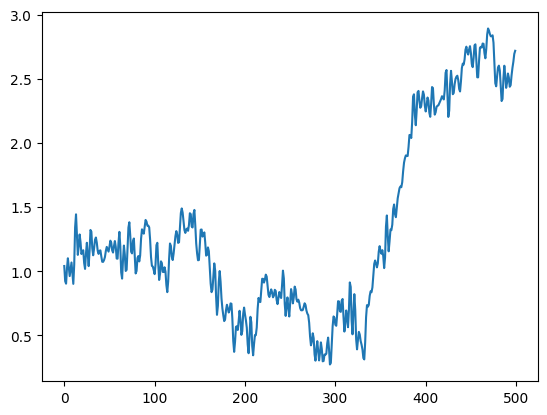

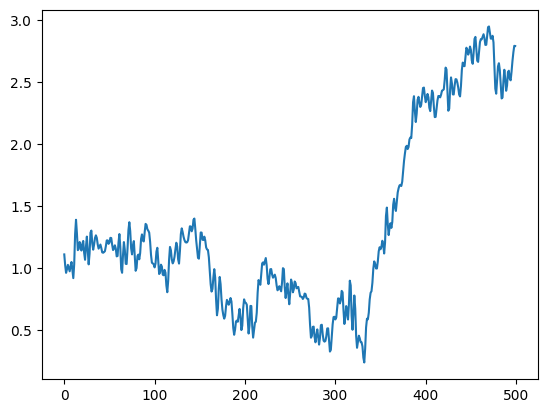

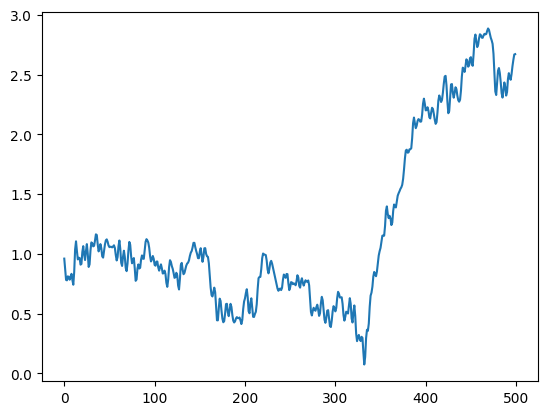

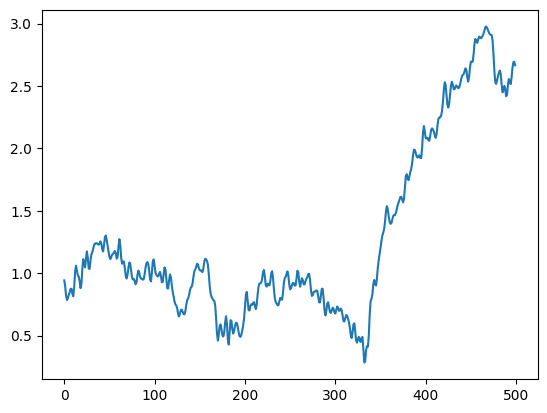

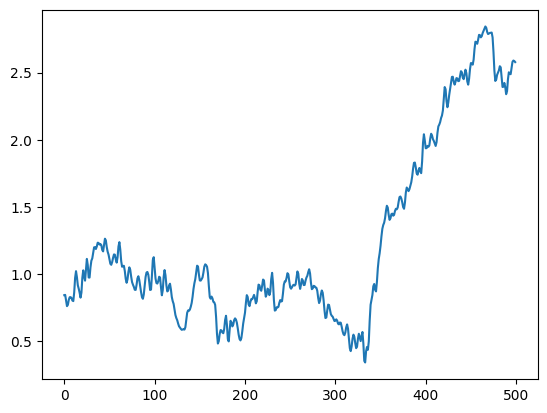

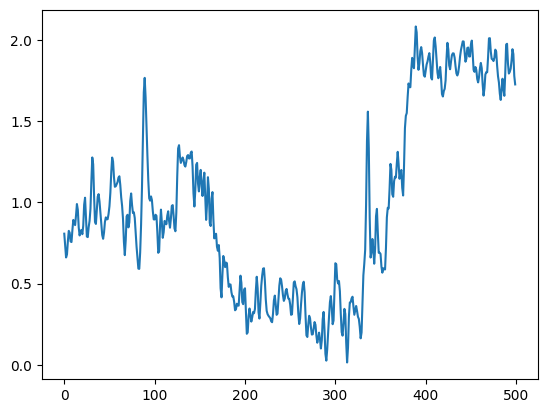

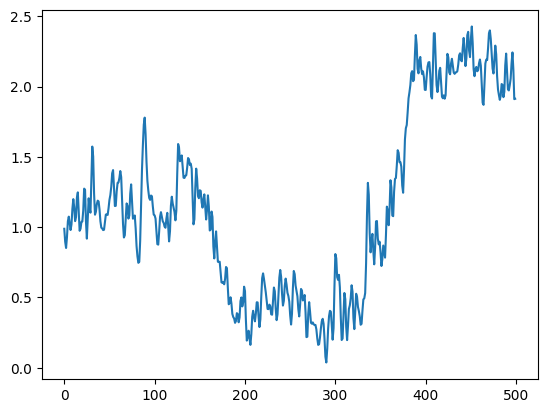

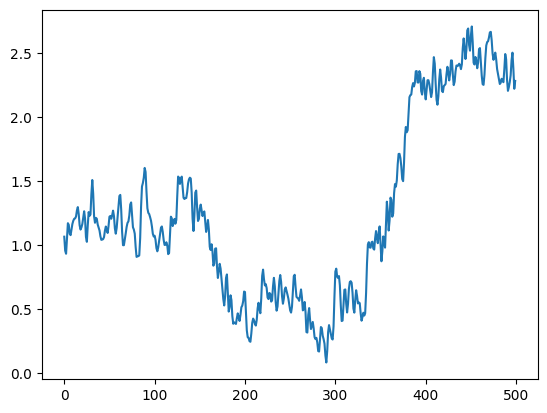

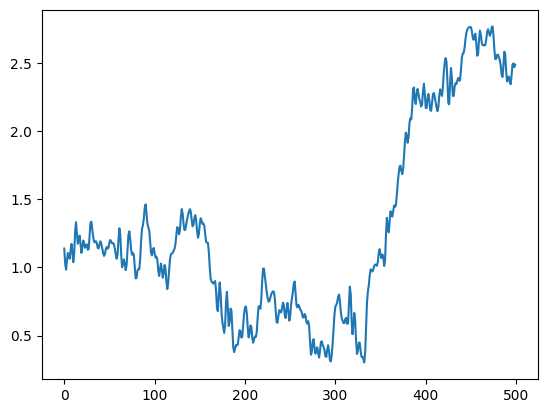

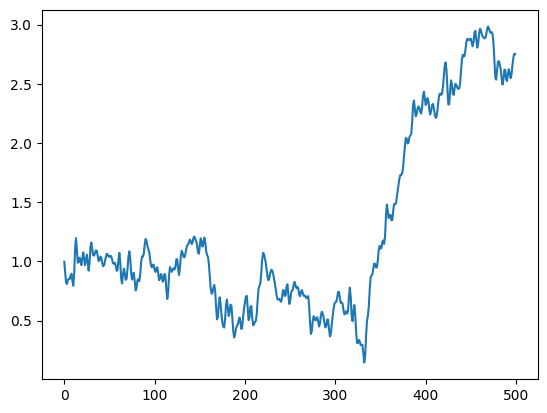

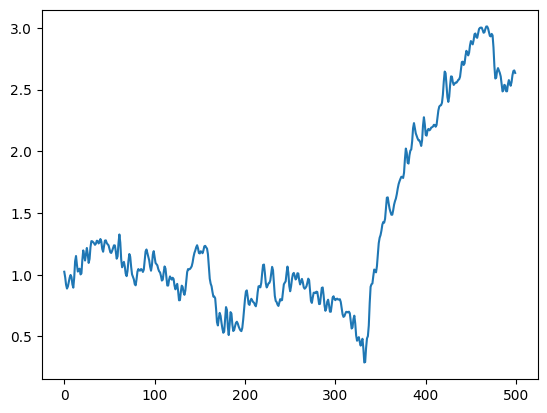

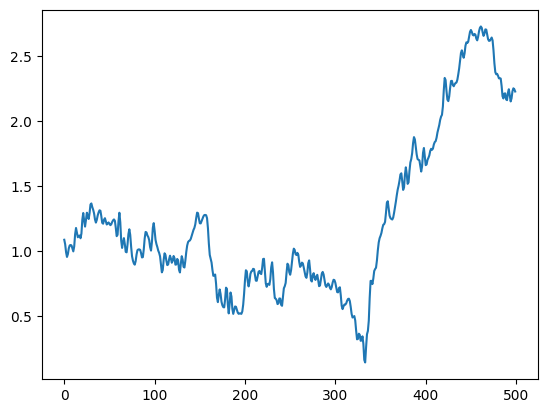

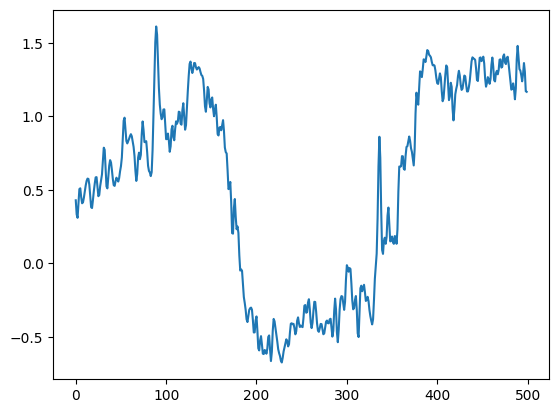

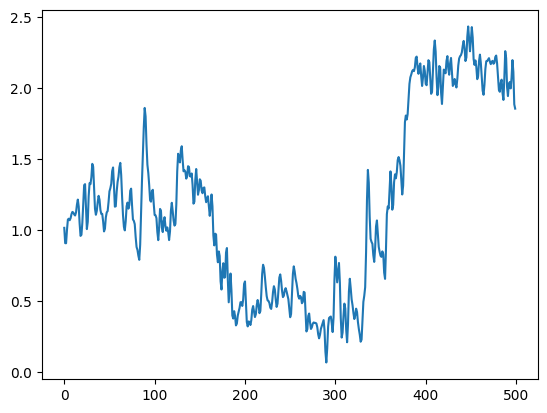

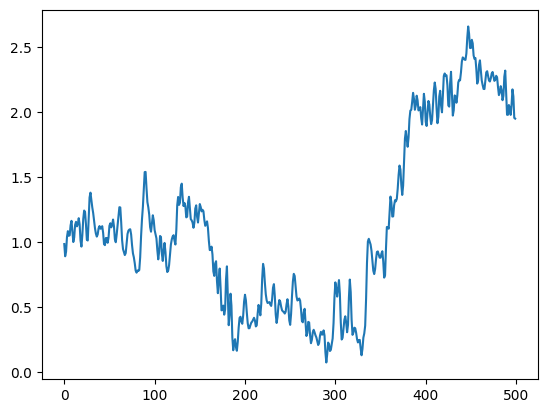

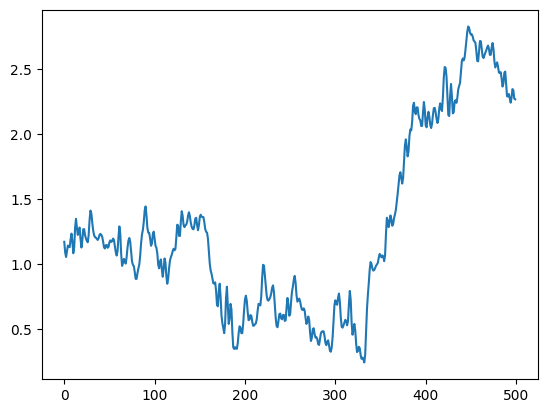

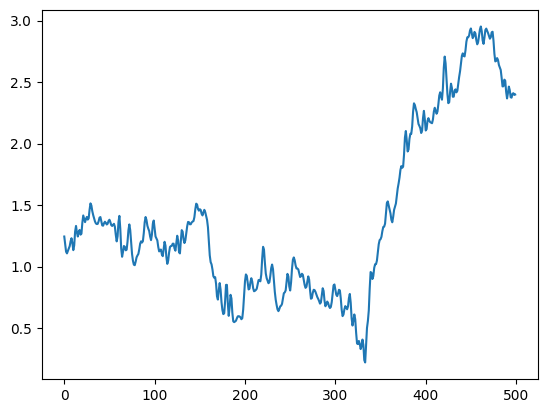

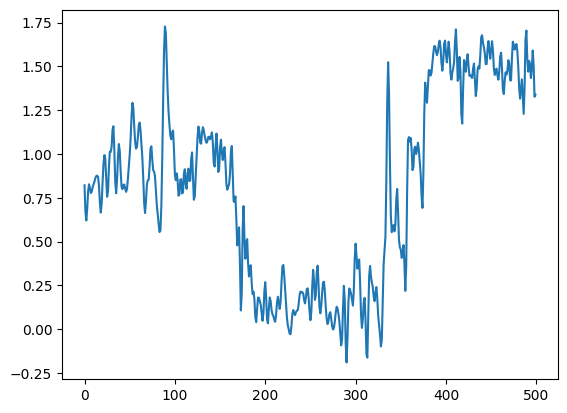

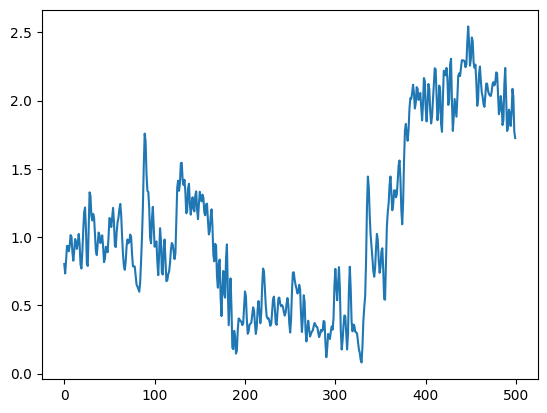

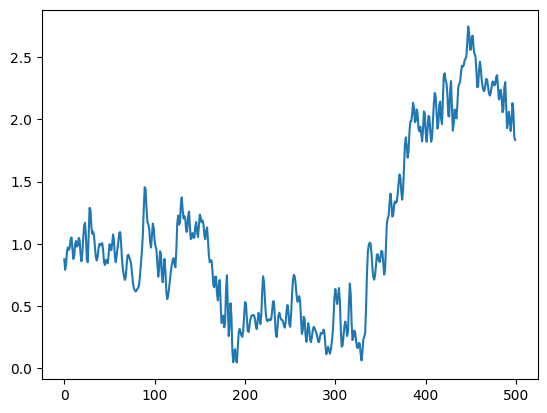

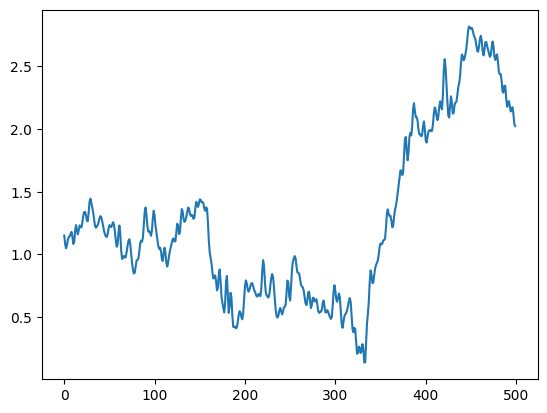

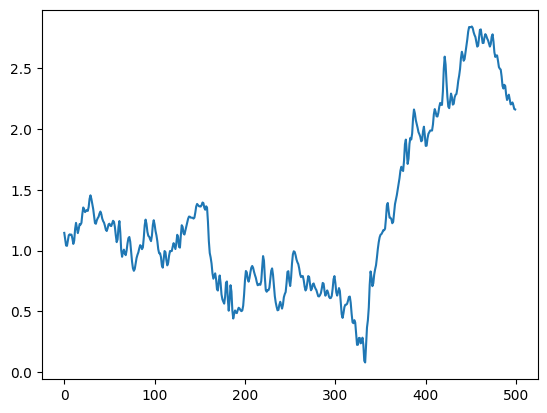

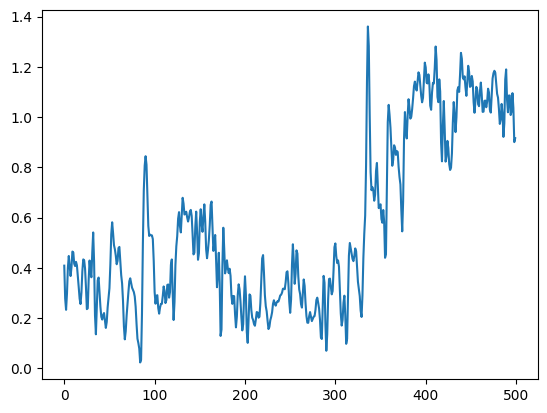

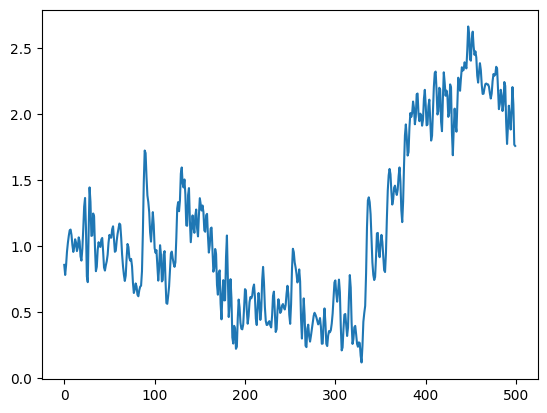

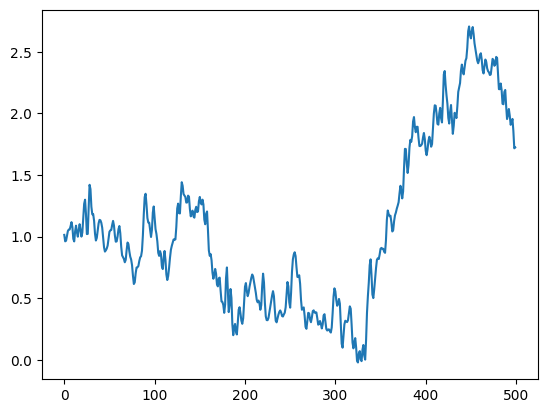

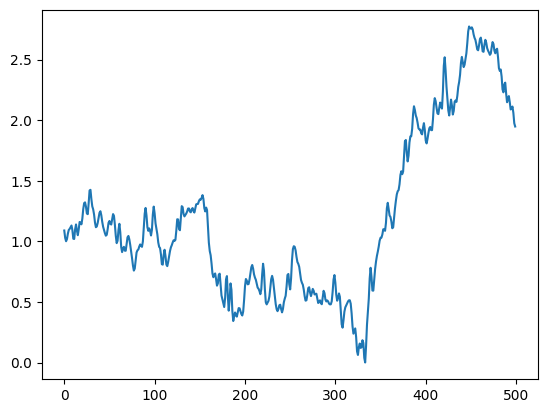

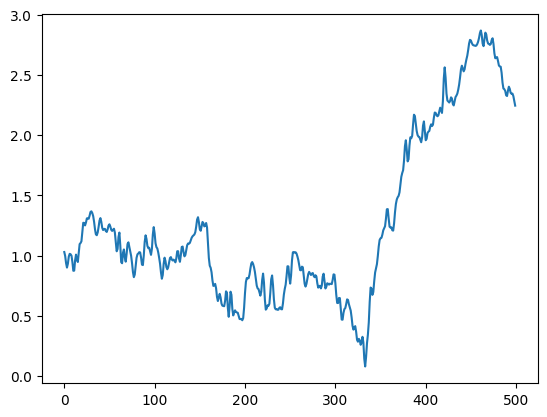

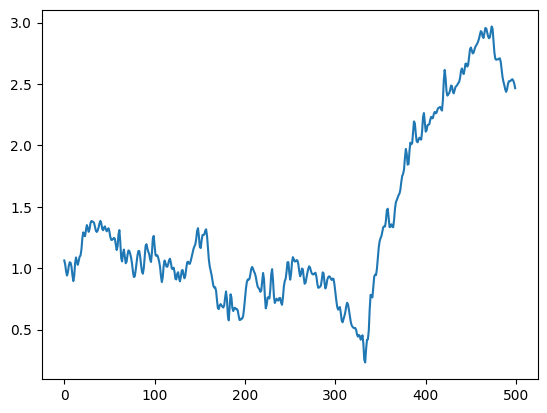

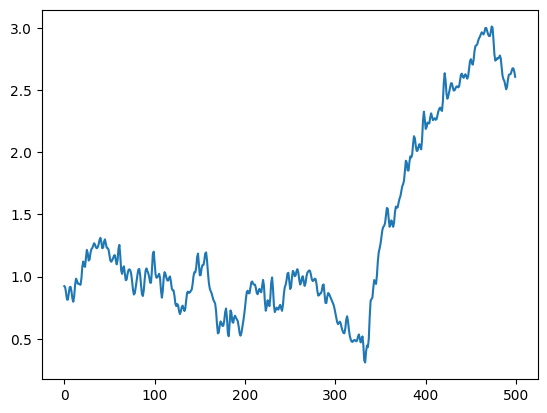

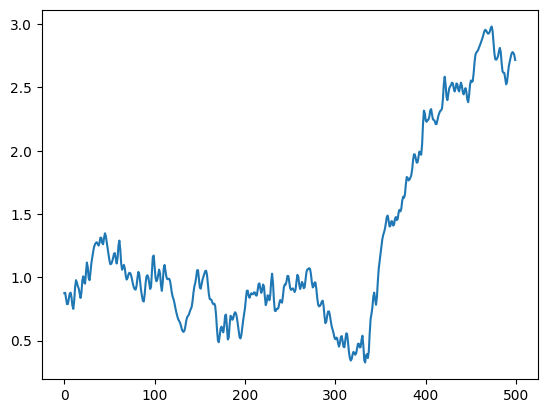

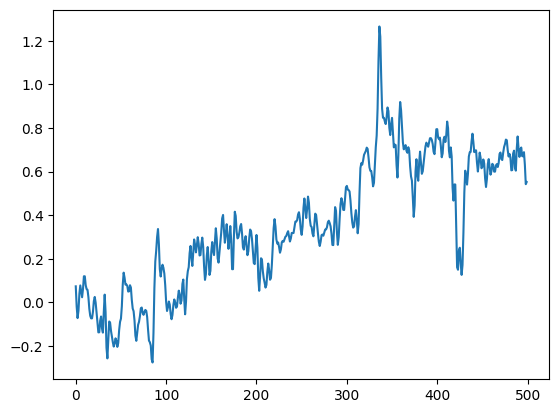

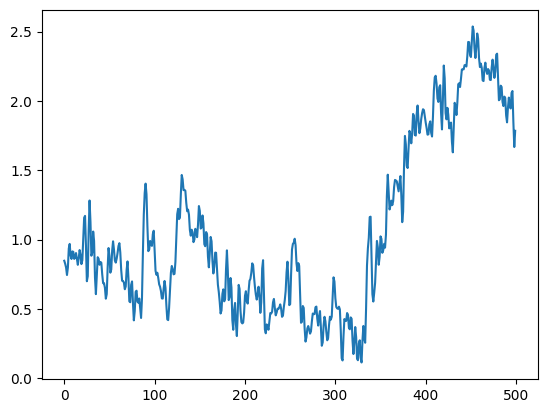

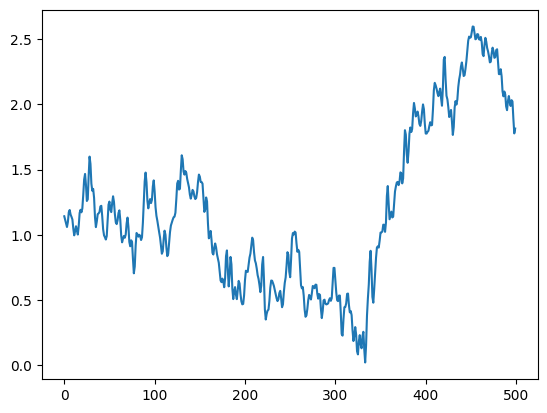

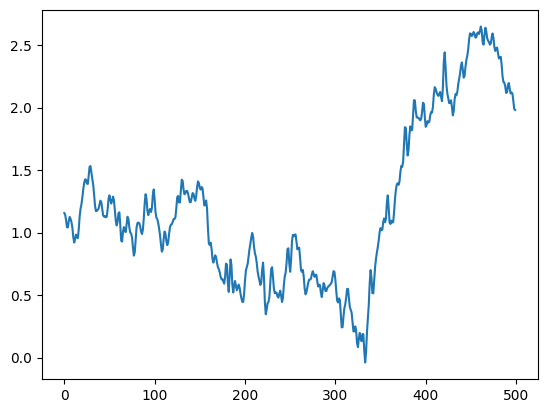

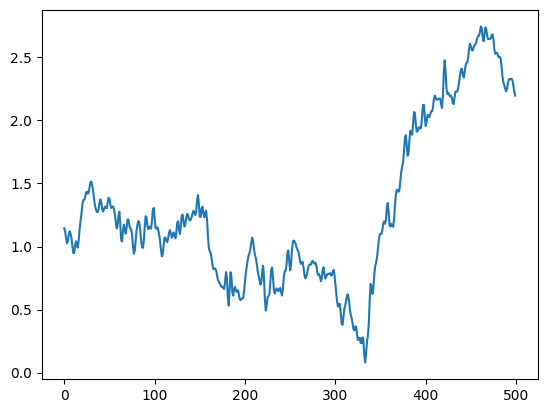

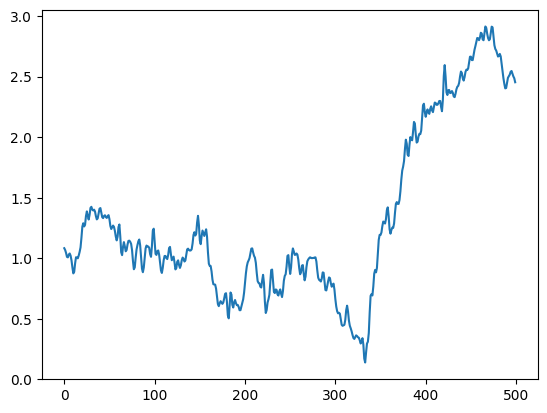

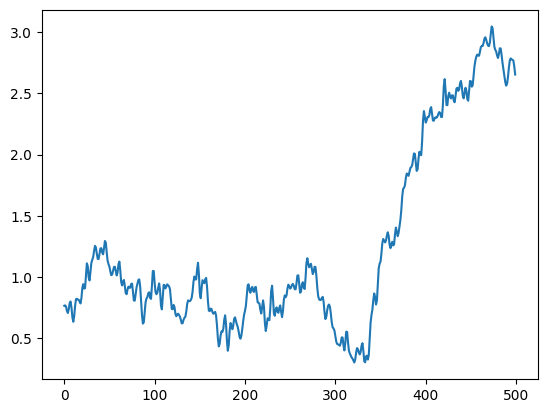

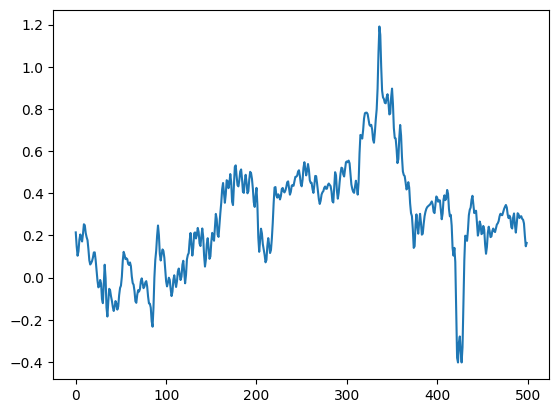

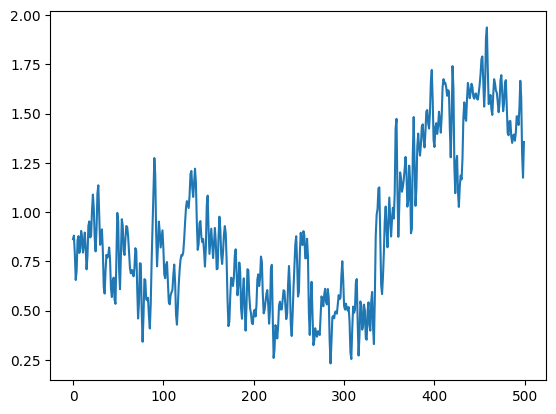

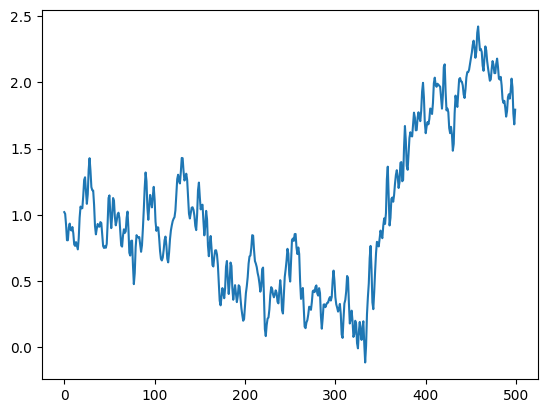

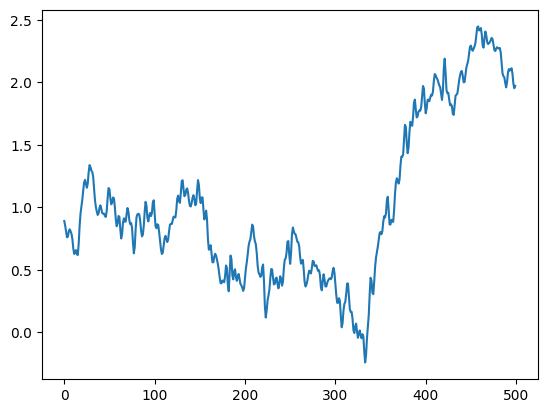

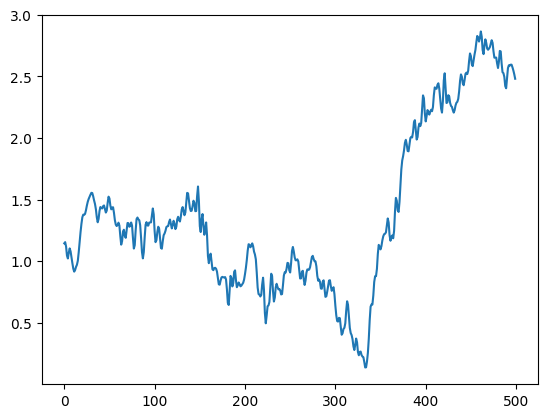

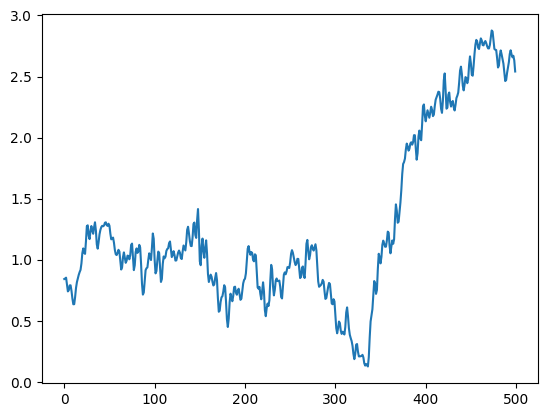

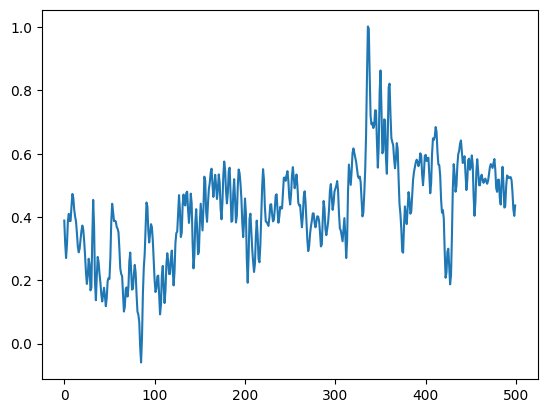

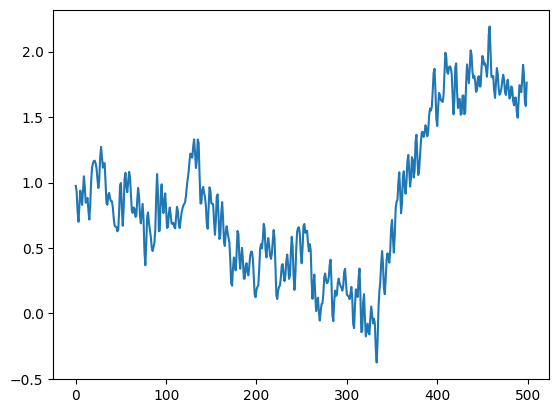

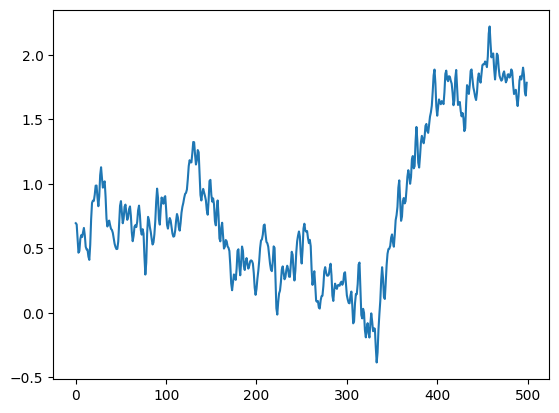

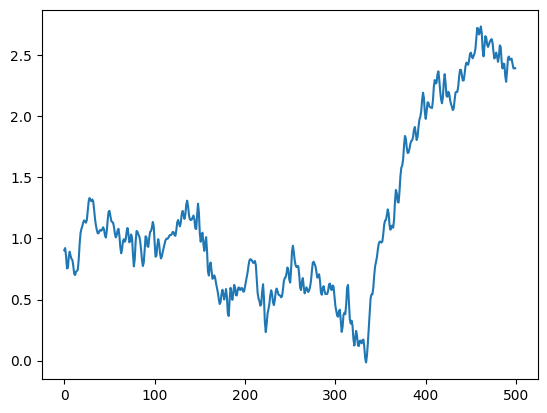

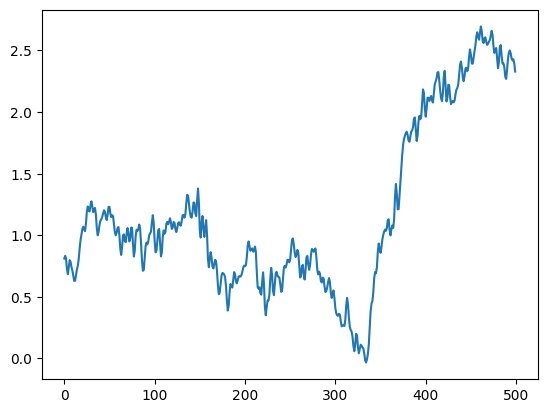

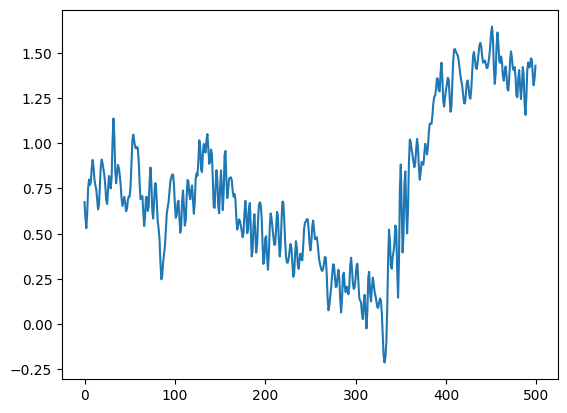

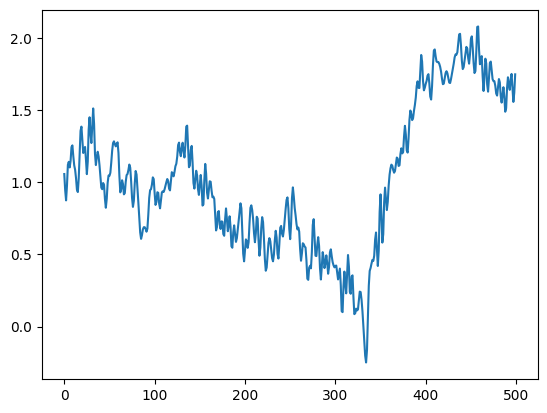

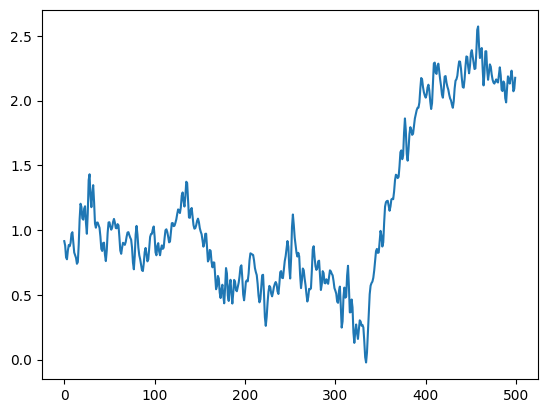

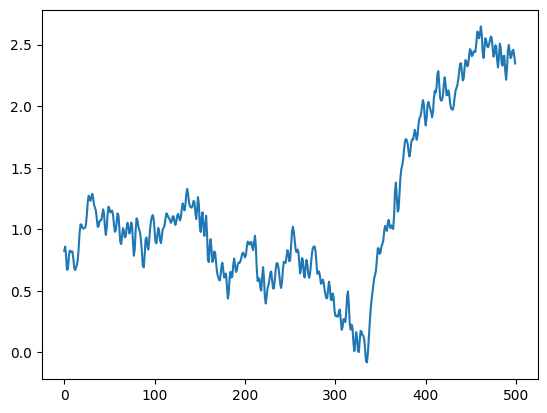

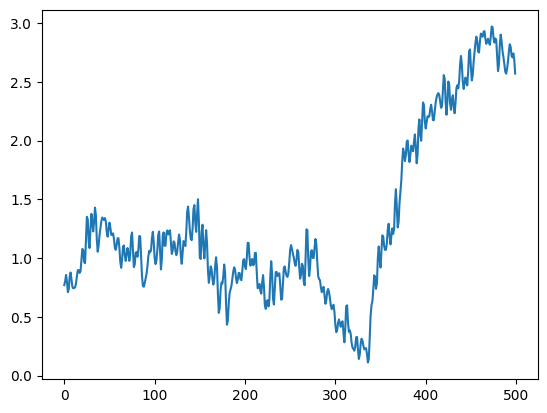

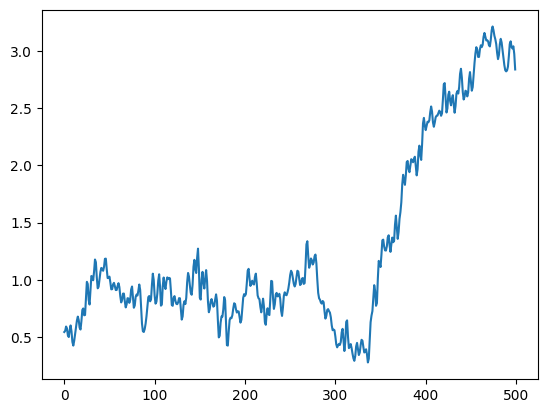

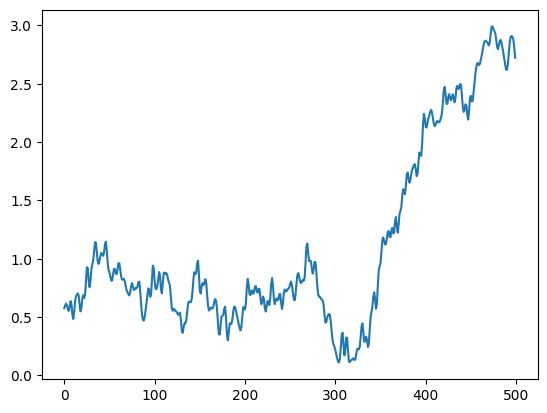

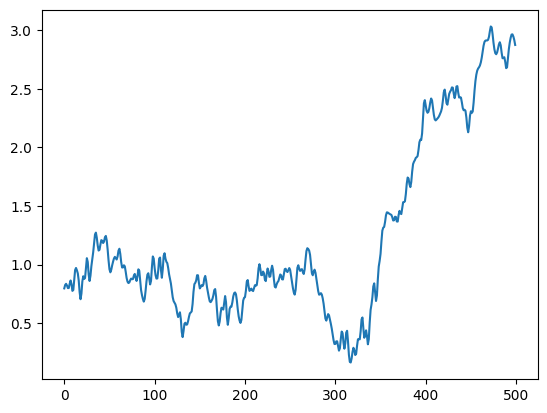


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [19]:
from braindecode.models import ShallowFBCSPNet
import lightning as L
dataloader = DataLoader(windows_ds, batch_size=32, shuffle=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ShallowFBCSPNet(n_outputs=2, n_chans=129, n_times=500).to(device)
lit = LitSSL(encoder=model)
trainer = L.Trainer(max_epochs=5, log_every_n_steps=1, default_root_dir='.', overfit_batches=0)
trainer.fit(lit, dataloader)

In [21]:
from braindecode.models import ShallowFBCSPNet
import lightning as L
dataloader = DataLoader(windows_ds, batch_size=32, shuffle=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ShallowFBCSPNet(n_outputs=2, n_chans=129, n_times=500).to(device)
# lit = LitSSL(encoder=model)
# trainer = L.Trainer(max_epochs=5, log_every_n_steps=1, default_root_dir='.', overfit_batches=0)
# trainer.fit(lit, dataloader)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model.train()
print(optimizer)
for epoch in range(5):
    for i, batch in enumerate(dataloader):
        X, Y = batch[0], batch[1]
        X = X.to(device)
        Y = Y.to(device)
        Z = model(X)
        # print(Z)
        # Z = lit_module.linear_head(Z)
        predictions = torch.nn.functional.softmax(Z, dim=1) 
        probs, predictions = torch.max(predictions, 1) # TODO assume that's the compatible way to cross entropy
        # print(probs, predictions)
        loss = nn.functional.cross_entropy(Z, Y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        print(f"epoch {epoch} - iter {i} - train_loss", loss.item())
        print(f'epoch {epoch} - iter {i} - train_accuracy', binary_accuracy(predictions, Y))

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)
epoch 0 - iter 0 - train_loss 1.3106088638305664
epoch 0 - iter 0 - train_accuracy tensor(0.4688, device='cuda:0')
epoch 0 - iter 1 - train_loss 0.7873296737670898
epoch 0 - iter 1 - train_accuracy tensor(0.7500, device='cuda:0')
epoch 0 - iter 2 - train_loss 1.384236216545105
epoch 0 - iter 2 - train_accuracy tensor(0.6562, device='cuda:0')
epoch 0 - iter 3 - train_loss 1.8954042196273804
epoch 0 - iter 3 - train_accuracy tensor(0.3438, device='cuda:0')
epoch 0 - iter 4 - train_loss 1.4825955629348755
epoch 0 - iter 4 - train_accuracy tensor(0.5625, device='cuda:0')
epoch 0 - iter 5 - train_loss 1.3856618404388428
epoch 0 - iter 5 - train_accuracy tensor(0.5312, device='cuda:0')
epoch 0 - iter 6 - train_loss 1.1718242168426514
epoch 0 - iter 6 - train_accuracy tensor(